In [20]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import jax
import jax.numpy as jnp

import equinox
import optax
import jax_tqdm

from flowjax.distributions import Normal

In [2]:
key = jax.random.PRNGKey(0)
n = 10_000
z = Normal().sample(key, (n,)) + 5

I0000 00:00:1698686692.902389   14022 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## flowjax loop

  0%|          | 0/1000 [00:00<?, ?it/s]

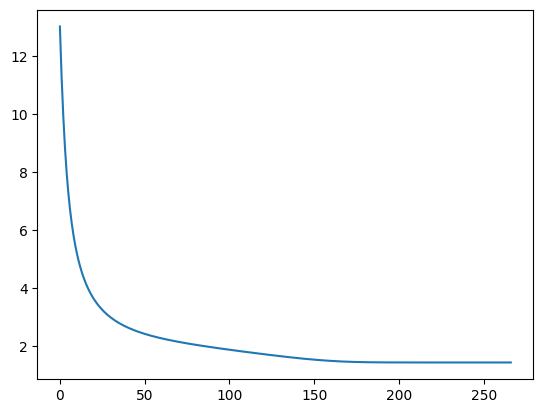

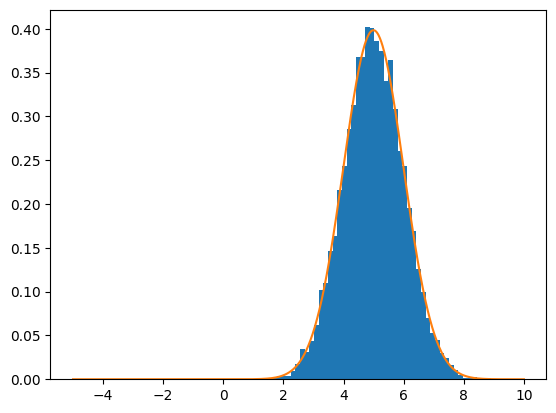

In [3]:
from flowjax.train.train_utils import get_batches, step, count_fruitless

def loss_fn_(static, params, x):
    dist = equinox.combine(static, params)
    return -dist.log_prob(x[:, None]).mean()

def fit_to_data(
    key,
    dist,
    x,
    condition=None,
    loss_fn=None,
    max_epochs=1_000,
    max_patience=10,
    batch_size=1_000,
    learning_rate=1e-2,
    optimizer=None,
    filter_spec=equinox.is_inexact_array,
    show_progress=True,
):

    data = (x,) if condition is None else (x, condition)
    data = tuple(jnp.asarray(a) for a in data)

    if optimizer is None:
        optimizer = optax.adam(learning_rate)

    if loss_fn is None:
        loss_fn = loss_fn_

    params, static = equinox.partition(dist, filter_spec)
    best_params = params
    opt_state = optimizer.init(params)

    losses = []

    loop = tqdm(range(max_epochs), disable=not show_progress)

    for _ in loop:
        key, *subkeys = jax.random.split(key, 3)
        train_data = [jax.random.permutation(subkeys[0], a) for a in data]

        batch_losses = []
        for batch in zip(*get_batches(train_data, batch_size), strict=True):
            params, opt_state, loss_i = step(
                optimizer,
                opt_state,
                loss_fn,
                params,
                static,
                *batch,
            )
            batch_losses.append(loss_i)
        losses.append(sum(batch_losses) / len(batch_losses))

        # loop.set_postfix({'loss': losses[-1]})
        if losses[-1] == min(losses):
            best_params = params

        elif count_fruitless(losses) > max_patience:
            # loop.set_postfix_str(f"{loop.postfix} (Max patience reached)")
            break

    dist = equinox.combine(best_params, static)
    return dist, losses

key = jax.random.PRNGKey(0)
dist, losses = fit_to_data(
    key, Normal(), z,
    max_epochs=1_000,
    max_patience=10,
    batch_size=1_000,
    learning_rate=1e-2,
)

plt.plot(losses)
plt.show()

plt.hist(z, bins=50, density=True)
x = jnp.linspace(-5, 10, 1_000)
plt.plot(x, jnp.exp(dist.log_prob(x[:, None])))
plt.show()

## naive loop with jitted loss

  0%|          | 0/1000 [00:00<?, ?it/s]

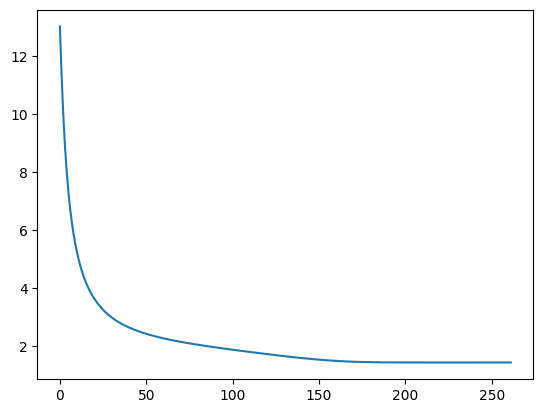

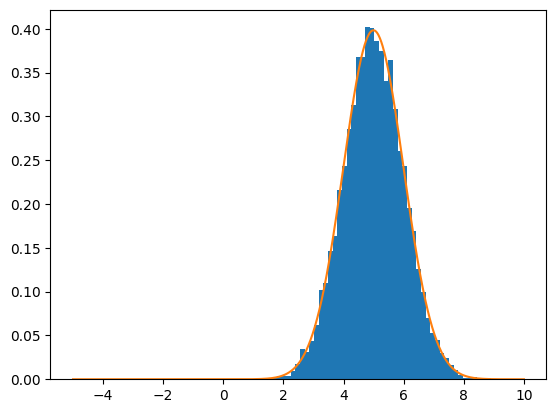

In [6]:
key = jax.random.PRNGKey(0)

dist = Normal()

params, static = equinox.partition(dist, equinox.is_inexact_array)
opt = optax.adam(1e-2)
state = opt.init(params)

# @jax.jit
def loss_fn(params, x):
    dist = equinox.combine(static, params)
    return -dist.log_prob(x[:, None]).mean()

@jax.jit
def loss_and_grads(params, x):
    return jax.value_and_grad(loss_fn)(params, x)

batch_size = 1_000
epochs = 1_000
patience = 10

n = z.shape[0]
trim = n - (n % batch_size) + 1
batches = z.shape[0] // batch_size

best_epoch = 0
best_loss = jnp.inf

losses = []
for epoch in tqdm(range(epochs)):
    key, key_ = jax.random.split(key)
    xs = jax.random.permutation(key_, z)[:trim].reshape(batches, batch_size)
    loss = 0
    for x in xs:
        loss_x, grads = loss_and_grads(params, x)
        loss += loss_x
        updates, state = opt.update(grads, state)
        params = optax.apply_updates(params, updates)
    loss /= batches

    losses.append(loss)
    if loss < best_loss:
        best_epoch = epoch
        best_loss = loss
        best_params = params

    if epoch - best_epoch > patience:
        break

dist = equinox.combine(static, best_params)

plt.plot(losses)
plt.show()

plt.hist(z, bins=50, density=True)
x = jnp.linspace(-5, 10, 1_000)
plt.plot(x, jnp.exp(dist.log_prob(x[:, None])))
plt.show()

## naive loop with jitted single batch

  0%|          | 0/1000 [00:00<?, ?it/s]

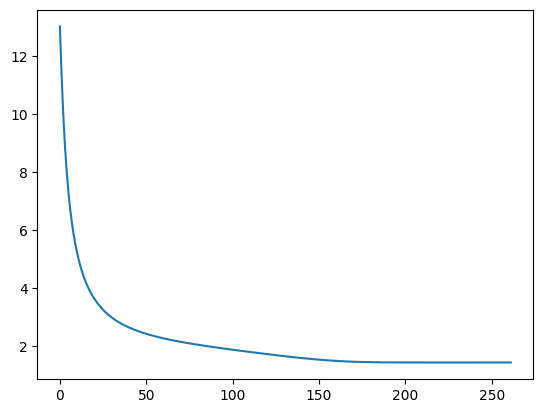

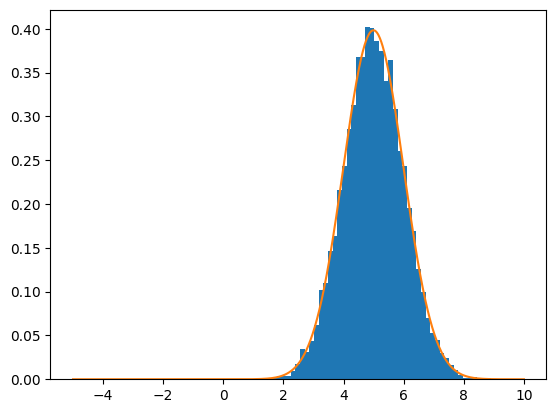

In [7]:
key = jax.random.PRNGKey(0)

dist = Normal()

params, static = equinox.partition(dist, equinox.is_inexact_array)
opt = optax.adam(1e-2)
state = opt.init(params)

# @jax.jit
def loss_fn(params, x):
    dist = equinox.combine(static, params)
    return -dist.log_prob(x[:, None]).mean()

# @jax.jit
def loss_and_grads(params, x):
    return jax.value_and_grad(loss_fn)(params, x)

@jax.jit
def single_batch(carry, x):
    params, state = carry
    loss, grads = loss_and_grads(params, x)
    updates, state = opt.update(grads, state)
    params = optax.apply_updates(params, updates)
    return (params, state), loss

batch_size = 1_000
epochs = 1_000
patience = 10

n = z.shape[0]
trim = n - (n % batch_size) + 1
batches = z.shape[0] // batch_size

best_epoch = 0
best_loss = jnp.inf

losses = []
for epoch in tqdm(range(epochs)):
    key, key_ = jax.random.split(key)
    xs = jax.random.permutation(key_, z)[:trim].reshape(batches, batch_size)
    loss = 0
    for x in xs:
        (params, state), loss_x = single_batch((params, state), x)
        loss += loss_x
    loss /= batches

    losses.append(loss)
    if loss < best_loss:
        best_epoch = epoch
        best_loss = loss
        best_params = params

    if epoch - best_epoch > patience:
        break

dist = equinox.combine(static, best_params)

plt.plot(losses)
plt.show()

plt.hist(z, bins=50, density=True)
x = jnp.linspace(-5, 10, 1_000)
plt.plot(x, jnp.exp(dist.log_prob(x[:, None])))
plt.show()

## scanned batches with jitted single epoch

  0%|          | 0/1000 [00:00<?, ?it/s]

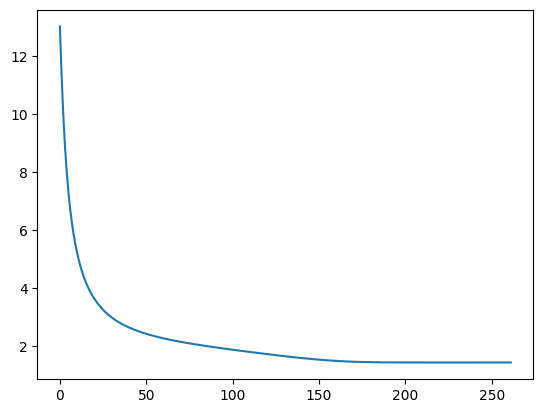

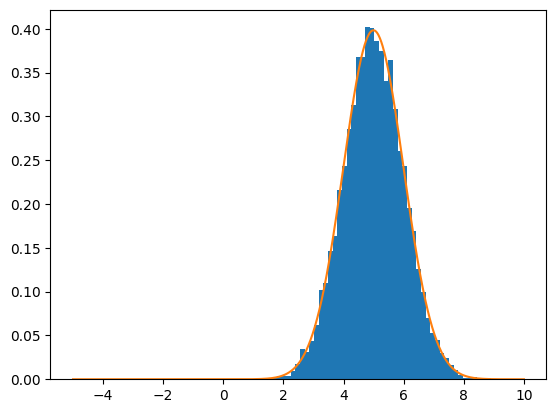

In [8]:
key = jax.random.PRNGKey(0)

dist = Normal()

batch_size = 1_000
epochs = 1_000
patience = 10

n = z.shape[0]
trim = n - (n % batch_size) + 1
batches = z.shape[0] // batch_size

params, static = equinox.partition(dist, equinox.is_inexact_array)
opt = optax.adam(1e-2)
state = opt.init(params)

# @jax.jit
def loss_fn(params, x):
    dist = equinox.combine(static, params)
    return -dist.log_prob(x[:, None]).mean()

# @jax.jit
def loss_and_grads(params, x):
    return jax.value_and_grad(loss_fn)(params, x)

# @jax.jit
def single_batch(carry, x):
    params, state = carry
    loss, grads = loss_and_grads(params, x)
    updates, state = opt.update(grads, state)
    params = optax.apply_updates(params, updates)
    return (params, state), loss

@jax.jit
def single_epoch(params, state, xs):
    (params, state), losses = jax.lax.scan(single_batch, (params, state), xs)
    loss = losses.mean()
    return params, state, loss

best_epoch = 0
best_loss = jnp.inf

losses = []
for epoch in tqdm(range(epochs)):
    key, key_ = jax.random.split(key)
    xs = jax.random.permutation(key_, z)[:trim].reshape(batches, batch_size)
    params, state, loss = single_epoch(params, state, xs)

    losses.append(loss)
    if loss < best_loss:
        best_epoch = epoch
        best_loss = loss
        best_params = params

    if epoch - best_epoch > patience:
        break

dist = equinox.combine(static, best_params)

plt.plot(losses)
plt.show()

plt.hist(z, bins=50, density=True)
x = jnp.linspace(-5, 10, 1_000)
plt.plot(x, jnp.exp(dist.log_prob(x[:, None])))
plt.show()

## scanned batches and progress bar with jitted single epoch

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

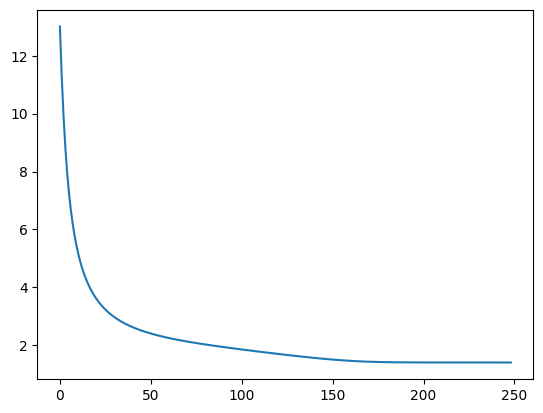

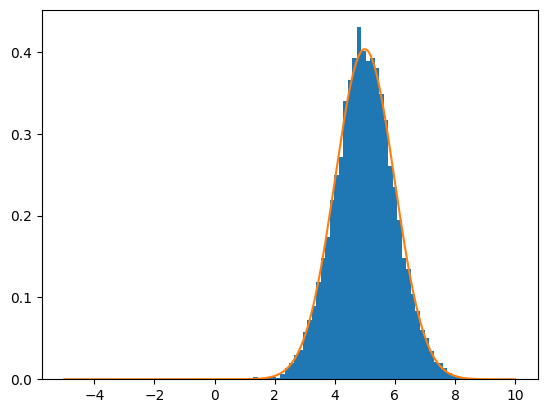

In [8]:
dist = Normal()

batch_size = 1_000
epochs = 1_000
patience = 10

n = z.shape[0]
trim = n - (n % batch_size) + 1
batches = z.shape[0] // batch_size

params, static = equinox.partition(dist, equinox.is_inexact_array)
opt = optax.adam(1e-2)
state = opt.init(params)

# @jax.jit
def loss_fn(params, x):
    dist = equinox.combine(static, params)
    return -dist.log_prob(x[:, None]).mean()

# @jax.jit
def loss_and_grads(params, x):
    return jax.value_and_grad(loss_fn)(params, x)

# @jax.jit
@jax_tqdm.scan_tqdm(batches)
def single_batch(carry, x):
    params, state = carry
    _, x = x
    loss, grads = loss_and_grads(params, x)
    updates, state = opt.update(grads, state)
    params = optax.apply_updates(params, updates)
    return (params, state), loss

@jax.jit
def single_epoch(params, state, xs):
    (params, state), losses = jax.lax.scan(
        single_batch, (params, state), (jnp.arange(batches), xs),
        )
    loss = losses.mean()
    return params, state, loss

best_epoch = 0
best_loss = jnp.inf

losses = []
for epoch in tqdm(range(epochs)):
    key, key_ = jax.random.split(key)
    xs = jax.random.permutation(key_, z)[:trim].reshape(batches, batch_size)
    params, state, loss = single_epoch(params, state, xs)

    losses.append(loss)
    if loss < best_loss:
        best_epoch = epoch
        best_loss = loss
        best_params = params

    if epoch - best_epoch > patience:
        break

dist = equinox.combine(static, best_params)

plt.plot(losses)
plt.show()

plt.hist(z, bins=50, density=True)
x = jnp.linspace(-5, 10, 1_000)
plt.plot(x, jnp.exp(dist.log_prob(x[:, None])))
plt.show()

## scanned batches and epochs with jitted all epochs and progress bar

  0%|          | 0/300 [00:00<?, ?it/s]

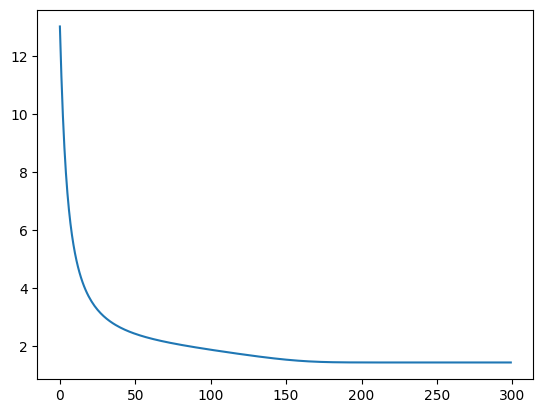

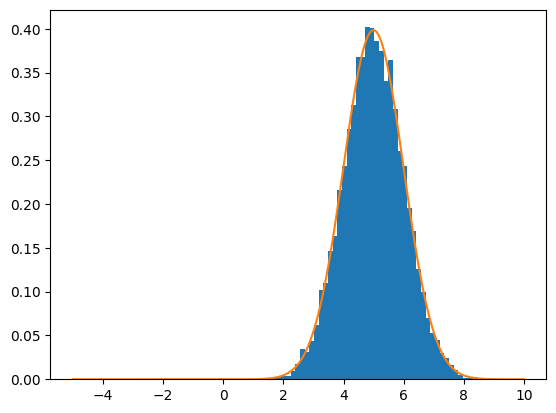

In [70]:
key = jax.random.PRNGKey(0)

dist = Normal()

batch_size = 1_000
epochs = 300

n = z.shape[0]
trim = n - (n % batch_size) + 1
batches = z.shape[0] // batch_size

params, static = equinox.partition(dist, equinox.is_inexact_array)
opt = optax.adam(1e-2)
state = opt.init(params)

# @jax.jit
def loss_fn(params, x):
    dist = equinox.combine(static, params)
    return -dist.log_prob(x[:, None]).mean()

# @jax.jit
def loss_and_grads(params, x):
    return jax.value_and_grad(loss_fn)(params, x)

# @jax.jit
def single_batch(carry, x):
    params, state = carry
    loss, grads = loss_and_grads(params, x)
    updates, state = opt.update(grads, state)
    params = optax.apply_updates(params, updates)
    carry = params, state
    y = loss
    return carry, y

# @jax.jit
@jax_tqdm.scan_tqdm(epochs, print_rate=100, message='epochs')
def single_epoch(carry, epoch):
    key, params, state = carry
    init = params, state
    key, key_ = jax.random.split(key)
    xs = jax.random.permutation(key_, z)[:trim].reshape(batches, batch_size)
    carry, ys = jax.lax.scan(single_batch, init, xs)
    params, state = carry
    batch_losses = ys
    carry = key, params, state
    y = batch_losses.mean(), jnp.array(jax.tree_util.tree_flatten(params)[0])
    return carry, y

@jax.jit
def all_epochs(key, params, state):
    init = key, params, state
    xs = jnp.arange(epochs)
    carry, ys = jax.lax.scan(single_epoch, init, xs)
    key, params, state = carry
    losses, params_list = ys
    best_epoch = jnp.argmin(losses)
    best_params = jax.tree_util.tree_unflatten(
        jax.tree_util.tree_flatten(params)[1],
        params_list[best_epoch],
        )
    dist = equinox.combine(static, best_params)
    return key, losses, dist

key, losses, dist = all_epochs(key, params, state)

plt.plot(losses)
plt.show()

plt.hist(z, bins=50, density=True)
x = jnp.linspace(-5, 10, 1_000)
plt.plot(x, jnp.exp(dist.log_prob(x[:, None])))
plt.show()